# Machine Annotation - BERTimbau - Relevance


---

For this research project, we will be utilizing the BERTimbau pretrained model. See citation below: \

@inproceedings { \
  souza2020bertimbau, \
  author    = {F{\'a}bio Souza and Rodrigo Nogueira and Roberto Lotufo}, \
  title     = {{BERT}imbau: pretrained {BERT} models for {B}razilian {P}ortuguese}, \
  booktitle = {9th Brazilian Conference on Intelligent Systems, {BRACIS}, Rio Grande do Sul, Brazil, October 20-23 (to appear)}, \
  year      = {2020} \
}


## Set Up
Mount to drive to access files for training the model:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Libraries

Install transformers:


In [2]:
!pip install transformers

Import libraries:

In [3]:
import transformers
from transformers import BertForSequenceClassification, BertTokenizer, pipeline
import pandas as pd
import numpy as np
from torch.utils.data import TensorDataset, random_split, Subset, RandomSampler, SequentialSampler, Dataset
import sklearn
from sklearn.model_selection import train_test_split
import os
import torch
import seaborn as sns
import random
import gc

Package versions:

In [4]:
print(f"Transformers version: {transformers.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Numpy version: {np.__version__}")
print(f"PyTorch version: {torch.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"Seaborn version: {sns.__version__}")

Transformers version: 4.41.2
Pandas version: 2.0.3
Numpy version: 1.25.2
PyTorch version: 2.3.0+cu121
Scikit-learn version: 1.2.2
Seaborn version: 0.13.1


### Connect to GPU
Connect to GPU if available:

In [5]:
import torch

# If there's a GPU available:
if torch.cuda.is_available():

    # Use GPU
    device = torch.device("cuda")

    print("There are available GPU(s).") # torch.cuda.device_cour

    print("We will use the GPU:", torch.cuda.get_device_name(0))

# If not

else:
    print("No GPU available, using CPU")
    device = torch.device("cpu")

There are available GPU(s).
We will use the GPU: Tesla T4


## GLOBAL VARIABLES - DATA
FILE_PATH = path to data file that will be used \

RELEVANCE = name of column representing relevance \
RELEVANCE_ID = column value that represents (relevance == True) \

POST = name of column representing the content of the tweet \
POST_DATE = name of column representing the post date \
POST_ID = name of column representing the tweet id

YEAR = year of when the dataset is from (to be used for file/folder naming)

In [11]:
FILE_PATH = '/content/drive/MyDrive/pesquisa-usp/relevant_tweets_2020-12-31.csv'
FOLDER_PATH = '/content/drive/MyDrive/pesquisa-usp/round-1/'

RELEVANCE = 'relevance'
RELEVANCE_ID = 'relevant'

POST = 'content'
POST_DATE = 'post_date'
POST_ID = 'tweet_id'

YEAR = '2020'


## GLOBAL VARIABLES - MODEL

In [7]:
import os

MODEL_TYPE = 'neuralmind/bert-base-portuguese-cased'
NUM_CLASSES = 2

SEED_VAL = 42

NUM_FOLDS = 5
NUM_EPOCHS = 5

L_RATE = 2e-5 # Testar novos valores
MAX_LEN = 256 # Testar novos valores
BATCH_SIZE = 32 # Testar novos valores
EPS = 1e-8 # Testar novos valores


NUM_CORES = os.cpu_count()

## Load BERT

In [8]:
from transformers import BertForSequenceClassification

# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    MODEL_TYPE,
    num_labels = NUM_CLASSES,
    output_attentions = False)

# Send the model to the device.
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

### Load Tokenizer

In [9]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained(MODEL_TYPE, do_lower_case=False)

Loading BERT tokenizer...


tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/210k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

## Prepare Dataset

---

In [12]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)

df = pd.read_csv(FILE_PATH)

In [13]:
# run this cell to display the dataset
df

,tweet_id,content,post_date,relevance
0,A522,A cabeça pensa onde o pé pisa. Quem governa de...,2020-09-15,relevant
1,A457,Sarto vai fazer um grande Programa de Enfrenta...,2020-11-20,relevant
2,A445,A Câmara dos Deputados votou hoje a MP que tra...,2020-12-18,relevant
3,A546,Tirar Bolsonaro do poder é uma questão de vida...,2020-11-10,relevant
4,A847,E a LIESA decidiu adiar os desfiles do #Carnav...,2020-09-24,relevant
...,...,...,...,...
2997,B2717,"""Estou exigindo a questão da cloroquina."" Algu...",2020-05-14,relevant
2998,B4586,#FeijoadaBeneficente | Participei neste sábado...,2020-03-09,irrelevant
2999,B4134,Aracaju tem um legado. Legado de desenvolvimen...,2020-06-10,irrelevant
3000,B2705,Estudo publicado pelo Imperial College estima ...,2020-04-01,irrelevant


###  Parsing

Display the class distribution of the dataset:

In [14]:
print("Tweet_Relevancies", YEAR + ":")

print(df[RELEVANCE].value_counts())

Tweet_Relevancies 2020:
relevance
irrelevant    1595
relevant      1407
Name: count, dtype: int64


Recode class names:

In [15]:
def condition(x):
    if x == RELEVANCE_ID:
        return 1
    else:
        return 0

df[RELEVANCE] = df[RELEVANCE].apply(condition)

# Check class distribution again:

print(df[RELEVANCE].value_counts())

relevance
0    1595
1    1407
Name: count, dtype: int64


Plot overall class distribution:

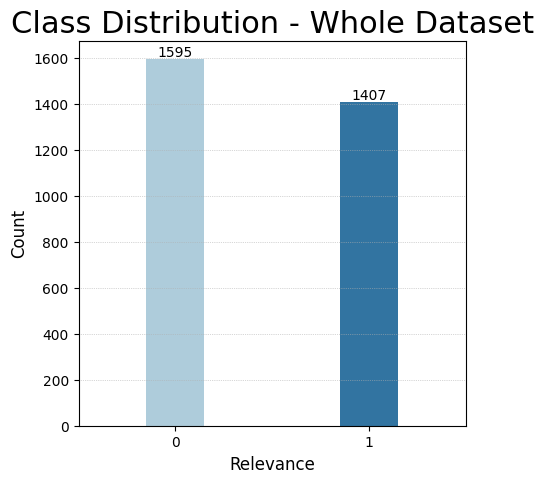

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
ax = sns.countplot(df,x=RELEVANCE,hue=RELEVANCE, palette="Paired", width=0.3,legend=False)
plt.title("Class Distribution - Whole Dataset",fontsize=22)
plt.xlabel('Relevance',fontsize=12)
plt.ylabel('Count',fontsize=12)

plt.grid(True,axis='y', linestyle=':', linewidth=0.5)

for i in ax.containers:
    ax.bar_label(i,)

plt.savefig(FOLDER_PATH+'ClassDistribution_WholeDataset.png', format='png', transparent = True, bbox_inches='tight',pad_inches=0.1)

### Split Train/Test Sets

Here, we separate **10%** of the total observations for the **test set**. \\
We use train_test_split so that the **data is shuffled** before splitting, using a seed (SEED_VAL) for the random state. \\
We use a stratifier to ensure that **class distribution proportions are maintained** in both sets. \\

**NOTE:** Train and Test sets should be tokenized and processed separately to avoid data leakage. \\

In [18]:
# from torch.utils.data import TensorDataset, random_split, Subset, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df,
                                     test_size = 0.1, # 10% for the test set
                                     stratify = df[RELEVANCE], # maintain class proportions
                                     random_state = SEED_VAL) # ensures reproducibility of results

Check class distributions:

In [19]:
print("training set class distribution:")
print(df_train[RELEVANCE].value_counts())
print("\ntest set class distribution:")
print(df_test[RELEVANCE].value_counts())

training set class distribution:
relevance
0    1435
1    1266
Name: count, dtype: int64

test set class distribution:
relevance
0    160
1    141
Name: count, dtype: int64


Plot class distributions across training/test sets:

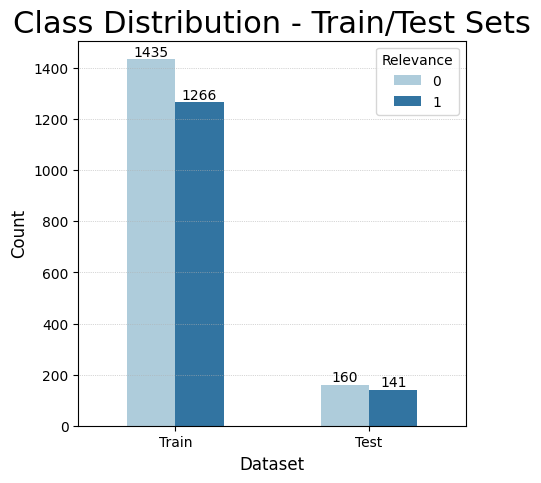

In [20]:
df_train['DATASET'] = 'Train'
df_test['DATASET'] = 'Test'

# Combine the two DataFrames
df_combined = pd.concat([df_train, df_test])

# Plot class distributions in a single plot
plt.figure(figsize=(5, 5))
ax = sns.countplot(x='DATASET', hue=RELEVANCE, data=df_combined, palette="Paired", width=0.5)
plt.title('Class Distribution - Train/Test Sets', fontsize=22)
plt.xlabel('Dataset',fontsize=12)
plt.ylabel('Count',fontsize=12)
plt.legend(title='Relevance')
plt.grid(True,axis='y', linestyle=':', linewidth=0.5)
for i in ax.containers:
    ax.bar_label(i,)

plt.savefig(FOLDER_PATH+'ClassDistribution_TrainTestSplit.png', format='png', transparent = True, bbox_inches='tight',pad_inches=0.1)

TEST (delete later):

In [21]:
df_test

,tweet_id,content,post_date,relevance,DATASET
1056,B3816,Bolsonaro insiste em brincar com coisa séria. ...,2020-07-22,1,Test
2088,B6222,para que não sejam retomadas as aulas presenci...,2020-04-28,0,Test
1512,A37,Nós da oposição na Câmara vamos acionar o STF ...,2020-10-21,1,Test
2734,B3907,Ontem no #EncontroDaEducação eu bem tratei de ...,2020-07-09,0,Test
919,B1880,"@xomano_eu Diante disso, o Hospital do Câncer ...",2020-12-16,0,Test
...,...,...,...,...,...
1582,A1347,Grande notícia! A parceria com a China na prod...,2020-08-11,1,Test
848,A978,Cientistas são ameaçados de morte; Fiocruz con...,2020-04-17,1,Test
1009,B4101,"Com mais 327 mortes, São Paulo bate novo recor...",2020-06-02,0,Test
2102,B2489,"Infelizmente, em Curitiba, o tratamento precoc...",2020-09-04,1,Test


### Custom Dataset Class

In [22]:
from torch.utils.data import Dataset

class TweetDataset(Dataset):
  def __init__(self, df):
    self.df_data = df

  def __getitem__(self, index):
    # Get the sentences from the dataframe
    sentence = self.df_data.iloc[index][POST]

    # Transform the sentence

    encoded_dict = tokenizer.encode_plus(sentence,  # Sentences to be tokenized
                                         add_special_tokens = True, # [CLS] and [SEP]
                                         padding = 'max_length',
                                         max_length = MAX_LEN,
                                         return_attention_mask = True, # Build attn. masks.
                                         return_tensors = 'pt', # Return pytorch tensors
                                        )


    # Torch Tensors

    padded_token_list = encoded_dict['input_ids'][0]
    att_mask = encoded_dict['attention_mask'][0]
    token_type_ids = encoded_dict['token_type_ids'][0]


    # Transforming the Target into a tensor

    target = torch.tensor(self.df_data.iloc[index][RELEVANCE])

    sample = (padded_token_list, att_mask, token_type_ids, target)

    return sample


  def __len__(self):

    return len(self.df_data)

### Create Test Dataloader

In [23]:
from torch.utils.data import DataLoader

df_test.reset_index(drop=True, inplace=True)
test_data = TweetDataset(df_test)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_CORES)

print(len(test_dataloader))
print(df_test.head())
print(df_test.index)


10
  tweet_id                                            content   post_date  \
0    B3816  Bolsonaro insiste em brincar com coisa séria. ...  2020-07-22   
1    B6222  para que não sejam retomadas as aulas presenci...  2020-04-28   
2      A37  Nós da oposição na Câmara vamos acionar o STF ...  2020-10-21   
3    B3907  Ontem no #EncontroDaEducação eu bem tratei de ...  2020-07-09   
4    B1880  @xomano_eu Diante disso, o Hospital do Câncer ...  2020-12-16   

   relevance DATASET  
0          1    Test  
1          0    Test  
2          1    Test  
3          0    Test  
4          0    Test  
RangeIndex(start=0, stop=301, step=1)


## Metric Functions

**classification_report_with_accuracy_score**(preds, labels):
- **preds** = a flat list of the binary predictions of the model
- **labels** = a flat list of the real classification of the corresponding predictions
- returns a DataFrame of the classification report made using preds and labels, which includes:

 **precision**, **recall**, and **F1-score** for each class.

 **macro average** and **weighted average** between both classes for precision, recall and F1-score.


 - returns overall **accuracy** of the model.

In [24]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Accuracy
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis = 1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Classification report
def classification_report_with_accuracy_score(preds, labels):
    report = classification_report(labels, preds, output_dict = True, zero_division = 0)

    df_class_report = pd.DataFrame(report).transpose()
    df_class_report = df_class_report.round(decimals=3) # for better readibility

    overall_accuracy = np.sum(preds == labels) / len(labels)

    return df_class_report, overall_accuracy

## Evaluate the BERTimbau Pre-Trained Model



Here, we will evaluate how BERTimbau (a pre-trained model) performs without having been trained on our curated dataset. We refer to the process of training BERTimbau specifically with our dataset as fine-tuning, which will be done later on.  

\\
We will evaluate through the following metrics: \\
- **Accuracy**: correct predictions/total number of instances
- **Precision**: percentage of instances that the model classified correctly for a given class
- **Recall**: percentage of instances of a given class that were classified correctly
- **F1-Score**: harmonic mean of precision and recall
- **Confusion Matrix**: represents number of actual outputs versus predicted outputs


###Test batches

In [25]:
model.eval()
torch.set_grad_enabled(False)

for i, test_batch in enumerate(test_dataloader):
  test_status = 'Batch ' + str(i+1) + ' / ' + str(len(test_dataloader))
  print(test_status, end='\r')

  b_input_ids = test_batch[0].to(device)
  b_input_mask = test_batch[1].to(device)
  b_token_type_ids = test_batch[2].to(device)


  outputs = model(b_input_ids,
                  token_type_ids=None,
                  attention_mask=b_input_mask,
                  return_dict = False)

  preds = outputs[0]
  test_preds = preds.detach().cpu().numpy()


  if i == 0:  # first batch
    stacked_test_preds = test_preds

  else:
    stacked_test_preds = np.vstack((stacked_test_preds, test_preds))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Each prediction returned by the model is a tuple - the logits are still raw.

The first value in the tuple represents the score given for Class 0, and the second value represents the score given for Class 1. \\
To get the real prediction, we take the max of both values to know whether the model's final prediction was Class 0 or Class 1. \\
For clarity, we will illustrate this below:

In [26]:
print("First 5 predictions as a raw logit tuple:\n", stacked_test_preds[0:6])
final_preds = np.argmax(stacked_test_preds, axis=1)
print("\nFirst 5 predictions final decisions after taking the max:\n", final_preds[0:6])

# print("\nAs shown above, Class 1 received a score of -0.08512102,\nwhich is bigger that the score given to Class 0.",
#       "\nTherefore, the model's final prediction is Class 1.")

First 5 predictions as a raw logit tuple:
 [[-0.04135213 -0.05552384]
 [-0.0521379   0.00634295]
 [-0.1272037   0.0030176 ]
 [-0.07340242 -0.03655992]
 [ 0.00401314  0.14903927]
 [ 0.02377372  0.1544214 ]]

First 5 predictions final decisions after taking the max:
 [0 1 1 1 1 1]


###Performance Scores

It must be noted that when reloading the model and rerunning the tests, a small fluctuation of values were observed in the performance scores. \
It was ensure that the Train/Test split of the dataset and the tokenization of the test set were the same.


In [27]:
labels = df_test[RELEVANCE]

report, accuracy = classification_report_with_accuracy_score(final_preds, labels)
# report is a DataFrame
print(report)

              precision  recall  f1-score  support
0                 0.571   0.175     0.268  160.000
1                 0.476   0.851     0.611  141.000
accuracy          0.492   0.492     0.492    0.492
macro avg         0.524   0.513     0.439  301.000
weighted avg      0.527   0.492     0.428  301.000


Plot table:

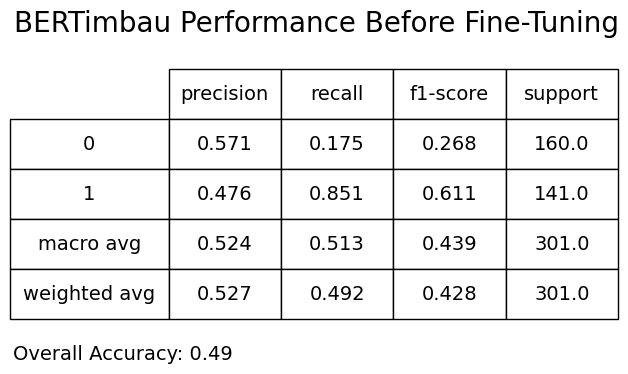

In [28]:
without_acc = report.loc[['0', '1', 'macro avg', 'weighted avg']]
fig, ax = plt.subplots(figsize=(2,4))
ax.axis('off')
table = pd.plotting.table(ax, without_acc, loc='right',cellLoc='center',rowLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(2.9, 3)
plt.title('BERTimbau Performance Before Fine-Tuning',
           loc='left',fontsize=20)
acc_str = 'Overall Accuracy: '+ str(accuracy.round(decimals=2))
fig.text(0.67, 0.08, acc_str, ha='center', fontsize=14)

plt.savefig(FOLDER_PATH+'PerformanceTable_PreTrainedModel.png', format='png', transparent = True, bbox_inches='tight',pad_inches=0.1)

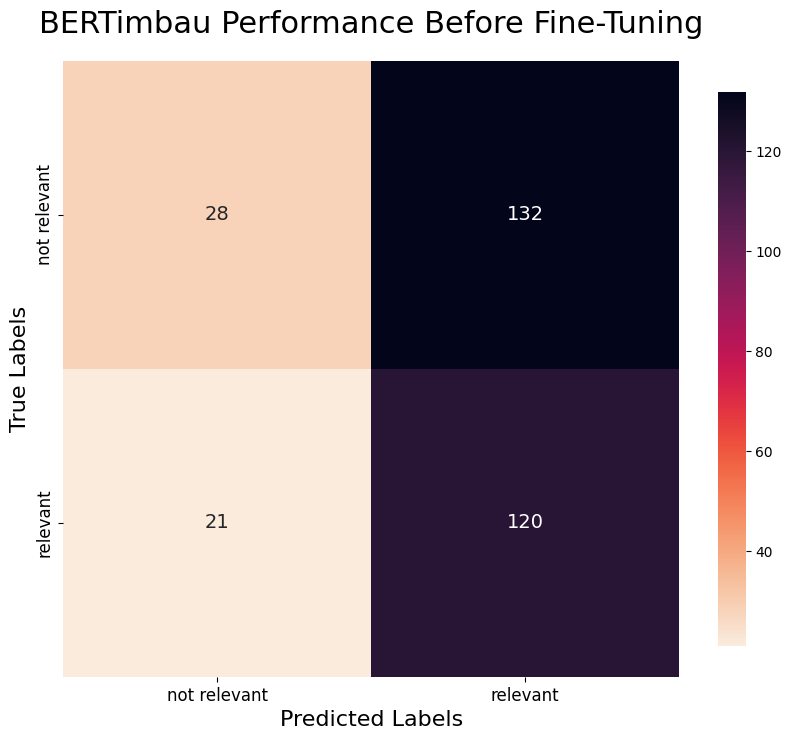

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns


confusion_matrix = confusion_matrix(df_test[RELEVANCE], final_preds)
fig = plt.figure(figsize=(10, 8))
ax = sns.heatmap(confusion_matrix, annot=True,cmap="rocket_r", fmt = '.0f',
            yticklabels=['not relevant', 'relevant'],
            xticklabels=['not relevant', 'relevant'],square=True,
                 annot_kws={"size": 14},cbar=True,
                 cbar_kws={'shrink': 0.9})
# ax.set_font
# plt.yticks(rotation=0)
plt.xticks(fontsize=12)  # X-axis tick labels font size
plt.yticks(fontsize=12)
# Add title and labels
plt.title('BERTimbau Performance Before Fine-Tuning', fontsize=22, loc='center',
          pad=20)
plt.xlabel('Predicted Labels', fontsize=16)
plt.ylabel('True Labels', fontsize=16)

plt.savefig(FOLDER_PATH+'ConfusionMatrix_PreTrainedModel.png', format='png', transparent = True, bbox_inches='tight',pad_inches=0.1)


##Train Model

We will now train BERTimbau on our curated dataset.\
The goal is to achieve significantly better evaluation scores compared to the pre-trained model's performance.

###Set the Seed

The seed will ensure reproducibility of these experiments:

In [30]:
random.seed(SEED_VAL)
np.random.seed(SEED_VAL)
torch.manual_seed(SEED_VAL)
torch.cuda.manual_seed_all(SEED_VAL)

###Remove Warnings

In [31]:
from transformers import AdamW
import random
import gc
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.utils import shuffle

# Remove Warnings

from transformers import logging

logging.set_verbosity_warning()

###Create Folds

In order to train the model, we must split the training dataset into train/validation sets.\
To do this, we will create folds such that each fold will have a different randomized (but seed controlled) dataset split.

In [32]:
skf = StratifiedKFold(n_splits = NUM_FOLDS,
                     shuffle = True,
                     random_state = SEED_VAL)

targets = df_train[RELEVANCE]

folds_list = skf.split(df_train,targets)

###Class Distribution Across Folds

<ipython-input-33-14d6d0ce593f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['DATASET'] = 'Train'
<ipython-input-33-14d6d0ce593f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['DATASET'] = 'Validation'
<ipython-input-33-14d6d0ce593f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

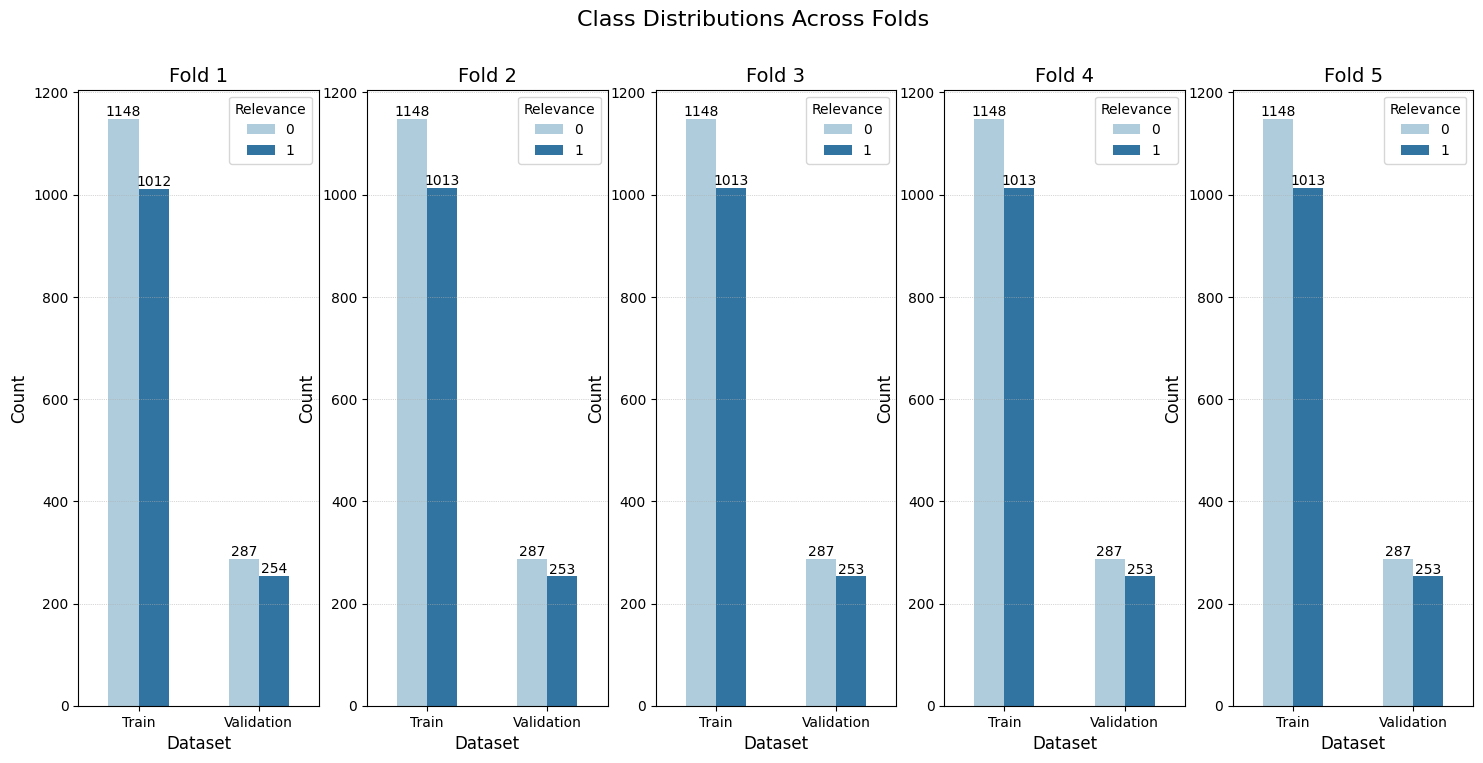

In [33]:
# create a figure with subplots
fig, axes = plt.subplots(1,NUM_FOLDS, figsize=(18, 8))
fig.suptitle('Class Distributions Across Folds', fontsize=16)

# fig.legend(title='Relevance')

# n = 1

for n, (train_index, val_index) in enumerate(skf.split(df_train,targets)):
  train = df_train.iloc[train_index,:]
  validation = df_train.iloc[val_index,:]

  # Group the datasets to be plotted:
  train['DATASET'] = 'Train'
  validation['DATASET'] = 'Validation'
  df_combined = pd.concat([train, validation])
  # plt.figure(figsize=(5, 5))

  sub_fig = axes[n]
  ax = sns.countplot(ax=sub_fig, x='DATASET', hue=RELEVANCE, data=df_combined, palette="Paired", width=0.5)

  title = 'Fold ' + str(n+1)
  sub_fig.set_title(title, fontsize=14)

  # Set labels and legend
  sub_fig.set_xlabel('Dataset', fontsize=12)
  sub_fig.set_ylabel('Count', fontsize=12)
  sub_fig.legend(title='Relevance', loc='upper right')
  sub_fig.grid(True, axis='y', linestyle=':', linewidth=0.5)

  # plt.xlabel('Dataset',fontsize=12)
  # plt.ylabel('Count',fontsize=12)
  # plt.legend(title='Relevance-')

  # plt.grid(True,axis='y', linestyle=':', linewidth=0.5)

  for i in ax.containers:
      ax.bar_label(i,)

  # print('\nTrain in Fold',str(n),'\n', train[RELEVANCE].value_counts())
  # print('Validation in Fold',str(n),'\n', validation[RELEVANCE].value_counts())
  # n += 1
# plt.show()

# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(FOLDER_PATH+'ClassDistribution_AcrossFolds.png', format='png', transparent = True, bbox_inches='tight',pad_inches=0.1)

In [34]:
# #TODO

# # Create a figure with subplots
# fig, axes = plt.subplots(1, NUM_FOLDS, figsize=(18, 8))
# fig.suptitle('Class Distributions Across Folds', fontsize=16)
# # print(len(list(enumerate(folds_list))))
# # Loop through each fold
# for n, (train_index, val_index) in enumerate(folds_list):
#     train = df_train.iloc[train_index, :]
#     validation = df_train.iloc[val_index, :]

#     # Group the datasets to be plotted
#     train['DATASET'] = 'Train'
#     validation['DATASET'] = 'Validation'
#     df_combined = pd.concat([train, validation])

#     # Select the subplot
#     sub_fig = axes[n]
#     ax = sns.countplot(ax=sub_fig, x='DATASET', hue=RELEVANCE, data=df_combined, palette="Paired", width=0.5)

#     # Set title for each subplot
#     title = 'Fold ' + str(n + 1)  # Adjust for 1-based index
#     sub_fig.set_title(title, fontsize=14)

#     # Set labels and legend
#     sub_fig.set_xlabel('Dataset', fontsize=12)
#     sub_fig.set_ylabel('Count', fontsize=12)
#     sub_fig.legend(title='Relevance', loc='upper right')
#     sub_fig.grid(True, axis='y', linestyle=':', linewidth=0.5)

#     # Add bar labels
#     for container in ax.containers:
#         ax.bar_label(container)

# # Adjust layout and show the plot
# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.show()

###Lists for Performance Scores

In [35]:
# PREVIOUS STUFF:
fold_val_acc_list = []
fold_val_f1macro_list = []
training_stats = []
clf_report = pd.DataFrame()


for i in range(0, NUM_FOLDS):
    fold_val_acc_list.append([])
    fold_val_f1macro_list.append([])

For ease of data visualization, we will store all performance scores in a list.\
Each nested list represents the epochs of a fold. \
Each epoch is a dictionary of its performance scores.

In other words, fold_reports is in the format: [fold_1,...fold_n] \

where fold_i = [epoch_1, ..., epoch_m] \

and epoch_j = {dictionary_of_scores} \

The dictionary will store:
- fold number
- epoch number
- train_loss
- val_loss
- report

In [36]:
# NEW STUFF
fold_reports = []

for i in range(NUM_FOLDS):
  fold_reports.append([])


###Training Loop

In [39]:
%%time

for fold_index, (train_index, val_index) in enumerate(skf.split(df_train,targets)):
  print('\n################## Fold Model Number', str(fold_index) + '/' + str(NUM_FOLDS), '##################')

  # ...........................................................................
  # Defining Dataloaders of Training and Validation
  # ...........................................................................

  # Train and Validation Sets
  train = df_train.iloc[train_index,:]
  val = df_train.iloc[val_index,:]


  # Reseting Indices so it will work
  train = train.reset_index(drop = True)
  val = val.reset_index(drop = True)


  # Tokenizing and Transforming Inputs (att masks, labels, etc.)
  train_data = TweetDataset(train)
  val_data = TweetDataset(val)

  # Creating Dataloaders for this Fold/Run
  train_dataloader = torch.utils.data.DataLoader(train_data,
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=False,
                                                 num_workers=NUM_CORES)

  val_dataloader = torch.utils.data.DataLoader(val_data,
                                               batch_size=BATCH_SIZE,
                                               shuffle=False,
                                               num_workers=NUM_CORES)


#------------------------------------------------------------------------------
  for epoch in range(0, NUM_EPOCHS):
#------------------------------------------------------------------------------

    #......................
    # Loading Fold Model
    #......................

    if epoch == 0:

      # Defining the model
      model = BertForSequenceClassification.from_pretrained(
          MODEL_TYPE,
          num_labels = NUM_CLASSES,
          output_attentions = False,
          output_hidden_states = False,
          )

      # Send the model to the device.

      model.to(device)

      optimizer = AdamW(model.parameters(),
                        lr = L_RATE,
                        eps = EPS
                        )

    else:

      # Getting the fold model
      path_model = 'model_' + str(fold_index) + '.bin'

      if os.path.exists(path_model):
        model.load_state_dict(torch.load(path_model))

      else:
        print(f"Error: {path_model} does not exist")

      # enviar o modelo para o device.
        model.to(device)


    print('============== Epoch {:} / {:} =============='.format(epoch + 1, NUM_EPOCHS))

    # For this epoch, store the val acc scores for each fold in this list.
    # We will use this list to calculate the cv at the end of the epoch.
    epoch_acc_scores_list = []
    epoch_stats = {'fold': fold_index + 1, # NEW STUFF
                   'epoch:': epoch + 1}

    # ==========================================================================
    #               Training
    # ==========================================================================

    stacked_val_labels = []
    targets_list = []

    print(" ")
    print('\nTraining...')
    print('')

    # put the model into train mode
    model.train()

    # This turns gradient calculations on and off.
    torch.set_grad_enabled(True)


    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Tracking variables
    total_f1_score = 0
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0


    for i, batch in enumerate(train_dataloader):

      train_status = 'Batch ' + str(i+1) + ' of ' + str(len(train_dataloader))

      print(train_status, end='\r')


      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_token_type_ids = batch[2].to(device)
      b_labels = batch[3].to(device)

      model.zero_grad()


      loss, logits = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask,
                           return_dict = False,
                           labels=b_labels)

      # Convert the loss from a torch tensor to a number.
      # Calculate the total loss.
      total_train_loss = total_train_loss + loss.item()

      # Zero the gradients
      optimizer.zero_grad()

      # Perform a backward pass to calculate the gradients.
      loss.backward()

      # Clip the norm of the gradients to 1.0.
      # This is to help prevent the "exploding gradients" problem.
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      # Use the optimizer to update Weights

      # Optimizer for GPU
      optimizer.step()

      # Optimizer for TPU
      # https://pytorch.org/xla/
      #xm.optimizer_step(optimizer, barrier=True)


    avg_train_loss = total_train_loss / len(train_dataloader)

    print('Total Train loss:' ,total_train_loss)
    print('Average Train Loss: ', avg_train_loss)

    epoch_stats['total_train_loss'] = total_train_loss
    epoch_stats['avg_train_loss'] = avg_train_loss

    # ==========================================================================
    #               Validation
    # ==========================================================================
    print(" ")
    print('=============================================')
    print('\nValidation...')
    print(' ')

    # Put the model in evaluation mode.
    model.eval()

    # Turn off the gradient calculations.
    # This tells the model not to compute or store gradients.
    # This step saves memory and speeds up validation.
    torch.set_grad_enabled(False)


    # Reset the total loss for this epoch.
    total_val_loss = 0

    # Tracking variables
    total_f1_score = 0
    total_weig_f1 = 0
    total_macro_f1 = 0
    total_eval_accuracy = 0
    total_eval_loss = 0


    for j, val_batch in enumerate(val_dataloader):

      val_status = 'Batch ' + str(j+1) + ' of ' + str(len(val_dataloader))

      print(val_status, end='\r')

      b_input_ids = val_batch[0].to(device)
      b_input_mask = val_batch[1].to(device)
      b_token_type_ids = val_batch[2].to(device)
      b_labels = val_batch[3].to(device)


      loss, logits = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask,
                           return_dict = False,
                           labels=b_labels)

      # Convert the loss from a torch tensor to a number.
      # Calculate the total loss.
      total_val_loss = total_val_loss + loss.item()


      # Move preds to the CPU
      val_preds = logits.detach().cpu().numpy()

      # Move the labels to the cpu
      targets_np = b_labels.to('cpu').numpy()

      # Append the labels to a numpy list
      targets_list.extend(targets_np)

      if j == 0: # Para o primeiro batch
        stacked_val_preds = val_preds

      else:
        stacked_val_preds = np.vstack((stacked_val_preds, val_preds))


      # Calculate the accuracy for this batch of test sentences, and
      # accumulate it over all batches. '
      total_eval_accuracy += flat_accuracy(val_preds, targets_np)
      total_f1_score += f1_score(np.argmax(val_preds,axis=1),
                                 targets_np,
                                 average = 'micro')

      total_weig_f1 += f1_score(np.argmax(val_preds, axis = 1),
                                  targets_np,
                                  average = 'weighted')


      total_macro_f1 += f1_score(np.argmax(val_preds, axis = 1),
                                  targets_np,
                                  average = 'macro')



    # .........................................................................
    # Calculate the validation accuracy for this fold
    # .........................................................................


    # Predictions and Labels
    y_true = targets_list
    y_pred = np.argmax(stacked_val_preds, axis=1)


    # Sklearn Accuracy
    val_acc = accuracy_score(y_true, y_pred)

    # Flat Accuracy
    avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # F1-score (Micro)
    avg_f1_score = total_f1_score / len(val_dataloader)
    print("  F1_score: {0:.2f}".format(avg_f1_score))

    # Macro F1
    avg_macro_f1 = total_macro_f1 / len(val_dataloader)
    print(" Macro F1-score: {0:.2f}".format(avg_macro_f1))

    # Weighted F1
    avg_weig_f1 = total_weig_f1 / len(val_dataloader)
    print(" Weighted F1-score: {0:.2f}".format(avg_weig_f1))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_val_loss / len(val_dataloader)


    # Class_report

    class_report, val_acc = classification_report_with_accuracy_score(y_pred.flatten(), y_true)

    epoch_acc_scores_list.append(avg_macro_f1)


    print('Val. loss:' ,total_val_loss)
    print('Val. acc: ', val_acc)
    print('Val. F1_Score', avg_f1_score)
    print('Classification Report: \n', class_report)


    # Training Report

    training_stats.append(
        {
            'epoch': epoch + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'f1_score_micro' : avg_f1_score,
            'macro_f1_score' : avg_macro_f1,
            'weighted_f1_score': avg_weig_f1,
            'classification_report':class_report,
            'fold' : fold_index

        }
      )

    # NEW STUFF
    epoch_stats['total_val_loss'] = total_val_loss
    epoch_stats['avg_val_loss'] = avg_val_loss
    epoch_stats['val_accuracy'] = val_acc
    epoch_stats['report'] = class_report

    fold_reports[fold_index].append(epoch_stats)


    # .........................................................................
    # Save the best model
    # .........................................................................

    if epoch == 0:

      # Save the Model
      model_name = 'model_' + str(fold_index) + '.bin'
      torch.save(model.state_dict(), model_name)
      print('Saved model as ', model_name)

    if epoch != 0:

      val_acc_list = fold_val_acc_list[fold_index]
      val_f1macro_list = fold_val_f1macro_list[fold_index]

      best_val_f1macro = max(val_f1macro_list)
      best_val_acc = max(val_acc_list)


      # Saving the model if it has the best F1-Macro
      if avg_macro_f1 > best_val_f1macro:

        model_name = 'model_' + str(fold_index) + '.bin'
        torch.save(model.state_dict(), model_name)
        print('F1-Macro improved. Saved model as ', model_name)


    # .....................................
    # Save the val_acc for this fold model
    # .....................................

    # Note: Don't do this before the above 'Save Model' code or
    # the save model code won't work. This is because the best_val_acc will
    # become current val accuracy.

    # fold_val_acc_list is a list of lists.
    # Each fold model has it's own list corresponding to the fold index.
    # Here we choose a list corresponding to the fold number and append the acc score to that list.
    fold_val_acc_list[fold_index].append(val_acc)
    fold_val_f1macro_list[fold_index].append(avg_macro_f1)




    # Use the garbage collector to save memory.
    gc.collect()


################## Fold Model Number 0/5 ##################


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


============== Epoch 1 / 5 ==============
 

Training...



/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 25.4281293079257
Average Train Loss:  0.3739430780577309
 

Validation...
 
  Accuracy: 0.94
  F1_score: 0.94
 Macro F1-score: 0.94
 Weighted F1-score: 0.94
Val. loss: 2.9532865695655346
Val. acc:  0.9390018484288355
Val. F1_Score 0.9383874239350912
Classification Report: 
               precision  recall  f1-score  support
0                 0.947   0.937     0.942  287.000
1                 0.930   0.941     0.935  254.000
accuracy          0.939   0.939     0.939    0.939
macro avg         0.939   0.939     0.939  541.000
weighted avg      0.939   0.939     0.939  541.000
Saved model as  model_0.bin
============== Epoch 2 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 7.606689224950969
Average Train Loss:  0.11186307683751426
 

Validation...
 
  Accuracy: 0.94
  F1_score: 0.94
 Macro F1-score: 0.94
 Weighted F1-score: 0.94
Val. loss: 3.8319355375133455
Val. acc:  0.9390018484288355
Val. F1_Score 0.9387677484787018
Classification Report: 
               precision  recall  f1-score  support
0                 0.981   0.902     0.940  287.000
1                 0.899   0.980     0.938  254.000
accuracy          0.939   0.939     0.939    0.939
macro avg         0.940   0.941     0.939  541.000
weighted avg      0.942   0.939     0.939  541.000
============== Epoch 3 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 7.844212629832327
Average Train Loss:  0.11535606808576952
 

Validation...
 
  Accuracy: 0.94
  F1_score: 0.94
 Macro F1-score: 0.94
 Weighted F1-score: 0.94
Val. loss: 3.4820278412662446
Val. acc:  0.9426987060998152
Val. F1_Score 0.9424442190669372
Classification Report: 
               precision  recall  f1-score  support
0                 0.971   0.920     0.945  287.000
1                 0.914   0.969     0.941  254.000
accuracy          0.943   0.943     0.943    0.943
macro avg         0.943   0.944     0.943  541.000
weighted avg      0.944   0.943     0.943  541.000
F1-Macro improved. Saved model as  model_0.bin
============== Epoch 4 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 4.3742565487045795
Average Train Loss:  0.06432730218683205
 

Validation...
 
  Accuracy: 0.94
  F1_score: 0.94
 Macro F1-score: 0.94
 Weighted F1-score: 0.94
Val. loss: 4.296205908525735
Val. acc:  0.944547134935305
Val. F1_Score 0.9439021298174443
Classification Report: 
               precision  recall  f1-score  support
0                 0.964   0.930     0.947  287.000
1                 0.924   0.961     0.942  254.000
accuracy          0.945   0.945     0.945    0.945
macro avg         0.944   0.945     0.944  541.000
weighted avg      0.945   0.945     0.945  541.000
F1-Macro improved. Saved model as  model_0.bin
============== Epoch 5 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 2.4325679395115003
Average Train Loss:  0.03577305793399265
 

Validation...
 
  Accuracy: 0.96
  F1_score: 0.96
 Macro F1-score: 0.95
 Weighted F1-score: 0.96
Val. loss: 4.140546198817901
Val. acc:  0.955637707948244
Val. F1_Score 0.9553118661257607
Classification Report: 
               precision  recall  f1-score  support
0                 0.949   0.969     0.959  287.000
1                 0.964   0.941     0.952  254.000
accuracy          0.956   0.956     0.956    0.956
macro avg         0.956   0.955     0.955  541.000
weighted avg      0.956   0.956     0.956  541.000
F1-Macro improved. Saved model as  model_0.bin

################## Fold Model Number 1/5 ##################


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


============== Epoch 1 / 5 ==============
 

Training...



/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 25.096137646585703
Average Train Loss:  0.3690608477439074
 

Validation...
 
  Accuracy: 0.96
  F1_score: 0.96
 Macro F1-score: 0.95
 Weighted F1-score: 0.96
Val. loss: 2.569813411682844
Val. acc:  0.9555555555555556
Val. F1_Score 0.9558823529411765
Classification Report: 
               precision  recall  f1-score  support
0                 0.952   0.965     0.958  287.000
1                 0.960   0.945     0.952  253.000
accuracy          0.956   0.956     0.956    0.956
macro avg         0.956   0.955     0.955  540.000
weighted avg      0.956   0.956     0.956  540.000
Saved model as  model_1.bin
============== Epoch 2 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 9.106124831363559
Average Train Loss:  0.1339136004612288
 

Validation...
 
  Accuracy: 0.95
  F1_score: 0.95
 Macro F1-score: 0.95
 Weighted F1-score: 0.95
Val. loss: 2.4662593994289637
Val. acc:  0.9537037037037037
Val. F1_Score 0.9537815126050421
Classification Report: 
               precision  recall  f1-score  support
0                 0.955   0.958     0.957  287.000
1                 0.952   0.949     0.950  253.000
accuracy          0.954   0.954     0.954    0.954
macro avg         0.954   0.953     0.954  540.000
weighted avg      0.954   0.954     0.954  540.000
============== Epoch 3 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 8.917394157499075
Average Train Loss:  0.13113814937498638
 

Validation...
 
  Accuracy: 0.96
  F1_score: 0.96
 Macro F1-score: 0.96
 Weighted F1-score: 0.96
Val. loss: 2.453102916944772
Val. acc:  0.9611111111111111
Val. F1_Score 0.9611344537815126
Classification Report: 
               precision  recall  f1-score  support
0                 0.972   0.955     0.963  287.000
1                 0.950   0.968     0.959  253.000
accuracy          0.961   0.961     0.961    0.961
macro avg         0.961   0.962     0.961  540.000
weighted avg      0.961   0.961     0.961  540.000
F1-Macro improved. Saved model as  model_1.bin
============== Epoch 4 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 3.9273785806726664
Average Train Loss:  0.05775556736283333
 

Validation...
 
  Accuracy: 0.96
  F1_score: 0.96
 Macro F1-score: 0.95
 Weighted F1-score: 0.96
Val. loss: 2.9376146784052253
Val. acc:  0.9555555555555556
Val. F1_Score 0.9558823529411765
Classification Report: 
               precision  recall  f1-score  support
0                 0.965   0.951     0.958  287.000
1                 0.946   0.960     0.953  253.000
accuracy          0.956   0.956     0.956    0.956
macro avg         0.955   0.956     0.955  540.000
weighted avg      0.956   0.956     0.956  540.000
============== Epoch 5 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 4.127843021648005
Average Train Loss:  0.06070357384776477
 

Validation...
 
  Accuracy: 0.96
  F1_score: 0.96
 Macro F1-score: 0.96
 Weighted F1-score: 0.96
Val. loss: 3.1588265320751816
Val. acc:  0.9592592592592593
Val. F1_Score 0.9595588235294118
Classification Report: 
               precision  recall  f1-score  support
0                 0.975   0.948     0.961  287.000
1                 0.943   0.972     0.957  253.000
accuracy          0.959   0.959     0.959    0.959
macro avg         0.959   0.960     0.959  540.000
weighted avg      0.960   0.959     0.959  540.000

################## Fold Model Number 2/5 ##################


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


============== Epoch 1 / 5 ==============
 

Training...



/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 27.408290155231953
Average Train Loss:  0.40306309051811695
 

Validation...
 
  Accuracy: 0.94
  F1_score: 0.94
 Macro F1-score: 0.94
 Weighted F1-score: 0.94
Val. loss: 3.208670947700739
Val. acc:  0.9388888888888889
Val. F1_Score 0.9390756302521008
Classification Report: 
               precision  recall  f1-score  support
0                 0.941   0.944     0.943  287.000
1                 0.937   0.933     0.935  253.000
accuracy          0.939   0.939     0.939    0.939
macro avg         0.939   0.939     0.939  540.000
weighted avg      0.939   0.939     0.939  540.000
Saved model as  model_2.bin
============== Epoch 2 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 8.46657360997051
Average Train Loss:  0.12450843544074279
 

Validation...
 
  Accuracy: 0.94
  F1_score: 0.94
 Macro F1-score: 0.94
 Weighted F1-score: 0.94
Val. loss: 3.613021520897746
Val. acc:  0.9425925925925925
Val. F1_Score 0.9422268907563025
Classification Report: 
               precision  recall  f1-score  support
0                 0.938   0.955     0.946  287.000
1                 0.948   0.929     0.938  253.000
accuracy          0.943   0.943     0.943    0.943
macro avg         0.943   0.942     0.942  540.000
weighted avg      0.943   0.943     0.943  540.000
F1-Macro improved. Saved model as  model_2.bin
============== Epoch 3 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 4.604480112204328
Average Train Loss:  0.06771294282653424
 

Validation...
 
  Accuracy: 0.95
  F1_score: 0.95
 Macro F1-score: 0.95
 Weighted F1-score: 0.95
Val. loss: 3.1325324401259422
Val. acc:  0.9518518518518518
Val. F1_Score 0.9522058823529411
Classification Report: 
               precision  recall  f1-score  support
0                 0.958   0.951     0.955  287.000
1                 0.945   0.953     0.949  253.000
accuracy          0.952   0.952     0.952    0.952
macro avg         0.951   0.952     0.952  540.000
weighted avg      0.952   0.952     0.952  540.000
F1-Macro improved. Saved model as  model_2.bin
============== Epoch 4 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 2.260639237705618
Average Train Loss:  0.033244694672141445
 

Validation...
 
  Accuracy: 0.95
  F1_score: 0.95
 Macro F1-score: 0.95
 Weighted F1-score: 0.95
Val. loss: 3.283127575647086
Val. acc:  0.9518518518518518
Val. F1_Score 0.9522058823529411
Classification Report: 
               precision  recall  f1-score  support
0                 0.968   0.941     0.954  287.000
1                 0.935   0.964     0.949  253.000
accuracy          0.952   0.952     0.952    0.952
macro avg         0.951   0.953     0.952  540.000
weighted avg      0.952   0.952     0.952  540.000
============== Epoch 5 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 1.991997793666087
Average Train Loss:  0.02929408520097187
 

Validation...
 
  Accuracy: 0.95
  F1_score: 0.95
 Macro F1-score: 0.95
 Weighted F1-score: 0.95
Val. loss: 3.5564187257550657
Val. acc:  0.9537037037037037
Val. F1_Score 0.9540441176470589
Classification Report: 
               precision  recall  f1-score  support
0                 0.958   0.955     0.956  287.000
1                 0.949   0.953     0.951  253.000
accuracy          0.954   0.954     0.954    0.954
macro avg         0.953   0.954     0.954  540.000
weighted avg      0.954   0.954     0.954  540.000
F1-Macro improved. Saved model as  model_2.bin

################## Fold Model Number 3/5 ##################


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


============== Epoch 1 / 5 ==============
 

Training...



/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 24.8402005918324
Average Train Loss:  0.3652970675269471
 

Validation...
 
  Accuracy: 0.93
  F1_score: 0.93
 Macro F1-score: 0.93
 Weighted F1-score: 0.93
Val. loss: 3.3941814452409744
Val. acc:  0.9351851851851852
Val. F1_Score 0.9348739495798319
Classification Report: 
               precision  recall  f1-score  support
0                 0.957   0.920     0.938  287.000
1                 0.913   0.953     0.932  253.000
accuracy          0.935   0.935     0.935    0.935
macro avg         0.935   0.936     0.935  540.000
weighted avg      0.936   0.935     0.935  540.000
Saved model as  model_3.bin
============== Epoch 2 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 7.6708459835499525
Average Train Loss:  0.11280655858161695
 

Validation...
 
  Accuracy: 0.95
  F1_score: 0.95
 Macro F1-score: 0.94
 Weighted F1-score: 0.95
Val. loss: 2.914015492424369
Val. acc:  0.9462962962962963
Val. F1_Score 0.9459033613445378
Classification Report: 
               precision  recall  f1-score  support
0                 0.948   0.951     0.950  287.000
1                 0.944   0.941     0.943  253.000
accuracy          0.946   0.946     0.946    0.946
macro avg         0.946   0.946     0.946  540.000
weighted avg      0.946   0.946     0.946  540.000
F1-Macro improved. Saved model as  model_3.bin
============== Epoch 3 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 3.4458211141172796
Average Train Loss:  0.05067383991348941
 

Validation...
 
  Accuracy: 0.96
  F1_score: 0.96
 Macro F1-score: 0.96
 Weighted F1-score: 0.96
Val. loss: 3.510699433274567
Val. acc:  0.9592592592592593
Val. F1_Score 0.959296218487395
Classification Report: 
               precision  recall  f1-score  support
0                 0.978   0.944     0.961  287.000
1                 0.939   0.976     0.957  253.000
accuracy          0.959   0.959     0.959    0.959
macro avg         0.959   0.960     0.959  540.000
weighted avg      0.960   0.959     0.959  540.000
F1-Macro improved. Saved model as  model_3.bin
============== Epoch 4 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 1.6067762128077447
Average Train Loss:  0.02362906195305507
 

Validation...
 
  Accuracy: 0.96
  F1_score: 0.96
 Macro F1-score: 0.96
 Weighted F1-score: 0.96
Val. loss: 3.589231570600532
Val. acc:  0.9574074074074074
Val. F1_Score 0.9574579831932774
Classification Report: 
               precision  recall  f1-score  support
0                 0.975   0.944     0.959  287.000
1                 0.939   0.972     0.955  253.000
accuracy          0.957   0.957     0.957    0.957
macro avg         0.957   0.958     0.957  540.000
weighted avg      0.958   0.957     0.957  540.000
============== Epoch 5 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 1.7737538112560287
Average Train Loss:  0.026084614871412188
 

Validation...
 
  Accuracy: 0.96
  F1_score: 0.96
 Macro F1-score: 0.96
 Weighted F1-score: 0.96
Val. loss: 3.824319983192254
Val. acc:  0.9592592592592593
Val. F1_Score 0.959296218487395
Classification Report: 
               precision  recall  f1-score  support
0                 0.968   0.955     0.961  287.000
1                 0.949   0.964     0.957  253.000
accuracy          0.959   0.959     0.959    0.959
macro avg         0.959   0.960     0.959  540.000
weighted avg      0.959   0.959     0.959  540.000

################## Fold Model Number 4/5 ##################


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


============== Epoch 1 / 5 ==============
 

Training...



/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 25.55756366252899
Average Train Loss:  0.3758465244489558
 

Validation...
 
  Accuracy: 0.95
  F1_score: 0.95
 Macro F1-score: 0.95
 Weighted F1-score: 0.95
Val. loss: 2.7902053520083427
Val. acc:  0.9518518518518518
Val. F1_Score 0.9519432773109244
Classification Report: 
               precision  recall  f1-score  support
0                 0.968   0.941     0.954  287.000
1                 0.935   0.964     0.949  253.000
accuracy          0.952   0.952     0.952    0.952
macro avg         0.951   0.953     0.952  540.000
weighted avg      0.952   0.952     0.952  540.000
Saved model as  model_4.bin
============== Epoch 2 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 8.806233765557408
Average Train Loss:  0.12950343772878542
 

Validation...
 
  Accuracy: 0.97
  F1_score: 0.97
 Macro F1-score: 0.96
 Weighted F1-score: 0.97
Val. loss: 2.2275346098467708
Val. acc:  0.9648148148148148
Val. F1_Score 0.9650735294117647
Classification Report: 
               precision  recall  f1-score  support
0                 0.969   0.965     0.967  287.000
1                 0.961   0.964     0.963  253.000
accuracy          0.965   0.965     0.965    0.965
macro avg         0.965   0.965     0.965  540.000
weighted avg      0.965   0.965     0.965  540.000
F1-Macro improved. Saved model as  model_4.bin
============== Epoch 3 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 4.661609836388379
Average Train Loss:  0.06855308582924087
 

Validation...
 
  Accuracy: 0.97
  F1_score: 0.97
 Macro F1-score: 0.96
 Weighted F1-score: 0.97
Val. loss: 2.5419487794861197
Val. acc:  0.9648148148148148
Val. F1_Score 0.9650735294117647
Classification Report: 
               precision  recall  f1-score  support
0                 0.979   0.955     0.966  287.000
1                 0.950   0.976     0.963  253.000
accuracy          0.965   0.965     0.965    0.965
macro avg         0.964   0.965     0.965  540.000
weighted avg      0.965   0.965     0.965  540.000
F1-Macro improved. Saved model as  model_4.bin
============== Epoch 4 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 2.918482076143846
Average Train Loss:  0.04291885406093891
 

Validation...
 
  Accuracy: 0.97
  F1_score: 0.97
 Macro F1-score: 0.97
 Weighted F1-score: 0.97
Val. loss: 2.6386946360580623
Val. acc:  0.9740740740740741
Val. F1_Score 0.9742647058823529
Classification Report: 
               precision  recall  f1-score  support
0                 0.989   0.962     0.975  287.000
1                 0.958   0.988     0.973  253.000
accuracy          0.974   0.974     0.974    0.974
macro avg         0.974   0.975     0.974  540.000
weighted avg      0.975   0.974     0.974  540.000
F1-Macro improved. Saved model as  model_4.bin
============== Epoch 5 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 1.5827718215296045
Average Train Loss:  0.02327605619896477
 

Validation...
 
  Accuracy: 0.97
  F1_score: 0.97
 Macro F1-score: 0.97
 Weighted F1-score: 0.97
Val. loss: 2.2106233023805544
Val. acc:  0.9722222222222222
Val. F1_Score 0.9724264705882353
Classification Report: 
               precision  recall  f1-score  support
0                 0.986   0.962     0.974  287.000
1                 0.958   0.984     0.971  253.000
accuracy          0.972   0.972     0.972    0.972
macro avg         0.972   0.973     0.972  540.000
weighted avg      0.973   0.972     0.972  540.000
CPU times: user 25min 18s, sys: 12min 59s, total: 38min 18s
Wall time: 39min 41s


##Model Evaluation

###Across Epochs

In [ ]:
# Summary of the training process

pd.set_option('display.precision', 2)

df_stats = pd.DataFrame(data = training_stats)
df_stats = df_stats.set_index('epoch')


df_stats

In [ ]:
class0 = []
i = 0
j = 0

for i in range(0,5):
  i += 1
  for j in range(0,5):
    metrics_0 = class0.append({'epoch': j + 1,
                            'fold': i - 1,
                            'precision': float(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[0]].iloc[:,0]),
                            'recall': float(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[0]].iloc[:,1]),
                            'f1-score': float(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[0]].iloc[:,2]),
                            'support': int(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[0]].iloc[:,3])
                            })

    j += 1



class0 = pd.DataFrame(data = class0)
class0.groupby(['fold']).mean()

In [ ]:
class1 = []
i = 0
j = 0

for i in range(0,5):
  i += 1
  for j in range(0,5):
    metrics_0 = class1.append({'epoch': j + 1,
                            'fold': i - 1,
                            'precision': float(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[1]].iloc[:,0]),
                            'recall': float(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[1]].iloc[:,1]),
                            'f1-score': float(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[1]].iloc[:,2]),
                            'support': int(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[1]].iloc[:,3])
                            })

    j += 1



class1 = pd.DataFrame(data = class1)

class1.groupby(['fold']).mean()


In [ ]:
grouped0 = class0.groupby('epoch').mean()
grouped1 = class1.groupby('epoch').mean()

In [ ]:
# Plot styling

sns.set(style = "darkgrid")

# Aumentando o tamanho do plot e da fonte

sns.set(font_scale = 1.5)
plt.rcParams['figure.figsize'] = (12,6)

In [ ]:
import matplotlib.pyplot as plt #changes made for relevant

# Set the style to a minimalist theme
plt.style.use('fivethirtyeight')

# changes for relevance:
plt.plot(grouped0['precision'], label = "not relevant")
plt.plot(grouped1['precision'], label = "relevant")
# plt.plot(grouped0['precision'], label = "Favourable")
# plt.plot(grouped1['precision'], label = "Unfavourable")
# plt.plot(grouped2['precision'], label = "Neutral")


# Labels

plt.title("Average Precision per Class")
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1.1))
plt.legend()

plt.show()

plt.savefig(FOLDER_PATH+'2020avgprecisionclass.png', format='png', transparent = True, bbox_inches='tight')

In [ ]:
# Set the style to a minimalist theme
plt.style.use('fivethirtyeight')

# changes for relevance:
plt.plot(grouped0['precision'], label = "not relevant")
plt.plot(grouped1['precision'], label = "relevant")
# plt.plot(grouped0['recall'], label = "Favourable")
# plt.plot(grouped1['recall'], label = "Unfavourable")
# plt.plot(grouped2['recall'], label = "Neutral")


# Labels

plt.title("Average Recall per Class")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1.1))
plt.legend()


plt.savefig(FOLDER_PATH+'2020avgrecallclass.png', format='png', transparent = True, bbox_inches='tight')

In [ ]:
# Set the style to a minimalist theme
plt.style.use('fivethirtyeight')

# changes for relevance:
plt.plot(grouped0['precision'], label = "not relevant")
plt.plot(grouped1['precision'], label = "relevant")
# plt.plot(grouped0['f1-score'], label = "Favourable")
# plt.plot(grouped1['f1-score'], label = "Unfavourable")
# plt.plot(grouped2['f1-score'], label = "Neutral")


# Labels

plt.title("Average F1-score per Class")
plt.xlabel("Epoch")
plt.ylabel("F1-Score")
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1.1))
plt.legend()


plt.savefig(FOLDER_PATH+'2020avgf1class.png', format='png', transparent = True, bbox_inches='tight')

In [ ]:
# Plot styling

sns.set(style = "darkgrid")

# Aumenttndo o tamanho do plot e da fonte

sns.set(font_scale = 1.5)
plt.rcParams['figure.figsize'] = (12,6)

# Curva de aprendizado

treino_loss = df_stats.groupby('epoch')['Training Loss'].mean()
valida_loss = df_stats.groupby('epoch')['Valid. Loss'].mean()

treino_valid = pd.merge(treino_loss, valida_loss, right_index = True,
               left_index = True)

In [ ]:
# Set the style to a minimalist theme
plt.style.use('fivethirtyeight')



plt.plot(treino_valid['Training Loss'], label = "Training")
plt.plot(treino_valid['Valid. Loss'], label = "Validation")

# Labels

plt.title("Average Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1))



plt.savefig(folder_path+'2020avgloss.png', format='png', transparent = True, bbox_inches='tight')

###Evaluate on Test Set

Here, we evaluate the new model the same way that we evaluated the pre-trained model. \
We do this to see if there was significant improvement after being trained with the curated dataset

###Test Batches

In [ ]:
model.eval()
torch.set_grad_enabled(False)

for i, test_batch in enumerate(test_dataloader):
  test_status = 'Batch ' + str(i+1) + ' / ' + str(len(test_dataloader))
  print(test_status, end='\r')

  b_input_ids = test_batch[0].to(device)
  b_input_mask = test_batch[1].to(device)
  b_token_type_ids = test_batch[2].to(device)


  outputs = model(b_input_ids,
                  token_type_ids=None,
                  attention_mask=b_input_mask,
                  return_dict = False)

  preds = outputs[0]
  test_preds = preds.detach().cpu().numpy()


  if i == 0:  # first batch
    stacked_test_preds = test_preds

  else:
    stacked_test_preds = np.vstack((stacked_test_preds, test_preds))


# Round predictions to either 0 or 1
final_preds = np.argmax(stacked_test_preds, axis=1)

###Performance Scores

In [ ]:
labels = df_test[RELEVANCE]

report, accuracy = classification_report_with_accuracy_score(final_preds, labels)
# report is a DataFrame
print(report)

In [ ]:
without_acc = report.loc[['0', '1', 'macro avg', 'weighted avg']]
fig, ax = plt.subplots(figsize=(2,4))
ax.axis('off')
table = pd.plotting.table(ax, without_acc, loc='right',cellLoc='center',rowLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(2.9, 3)
plt.title('BERTimbau Performance After Fine-Tuning',
           loc='left',fontsize=20)
acc_str = 'Overall Accuracy: '+ str(accuracy.round(decimals=2))
fig.text(0.67, 0.08, acc_str, ha='center', fontsize=14)

plt.savefig(FOLDER_PATH+'PerformanceTable_TrainedModel.png', format='png', transparent = True, bbox_inches='tight',pad_inches=0.1)

Matrix:

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns


confusion_matrix = confusion_matrix(df_test[RELEVANCE], final_preds)
fig = plt.figure(figsize=(10, 8))
ax = sns.heatmap(confusion_matrix, annot=True,cmap="rocket_r", fmt = '.0f',
            yticklabels=['not relevant', 'relevant'],
            xticklabels=['not relevant', 'relevant'],square=True,
                 annot_kws={"size": 14},cbar=True,
                 cbar_kws={'shrink': 0.9})
# ax.set_font
# plt.yticks(rotation=0)
plt.xticks(fontsize=12)  # X-axis tick labels font size
plt.yticks(fontsize=12)
# Add title and labels
plt.title('BERTimbau Performance After Fine-Tuning', fontsize=22, loc='center',
          pad=20)
plt.xlabel('Predicted Labels', fontsize=16)
plt.ylabel('True Labels', fontsize=16)

plt.savefig(FOLDER_PATH+'ConfusionMatrix_TrainedModel.png', format='png', transparent = True, bbox_inches='tight',pad_inches=0.1)
